# Lee's Frame (Continuum Elements)

The problem provided in this example is a L frame with pinned-pinned boundary conditions subjected to a point load at the center on top of the frame. The frame is modeled using continuum elements with a compressible neo-Hookean material constitutive law. 

<img src="imgs/lee_frame.png" width="600">


# Install FEniCS and FEniCS arclength in Google Colab environment 
This step will automatically skip if not in a Google Colab environment.

In [2]:
try:
  import google.colab
  !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
  !git clone https://github.com/pprachas/fenics_arclength.git
  %cd fenics_arclength
  !pip install .
  %cd examples/force_control/continuum

except ImportError:
  pass

In [1]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import os
from arc_length.force_control_solver import force_control # import force control formulation of arc-length solver


parameters["form_compiler"]["cpp_optimize"] = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

## Import Mesh and define function space

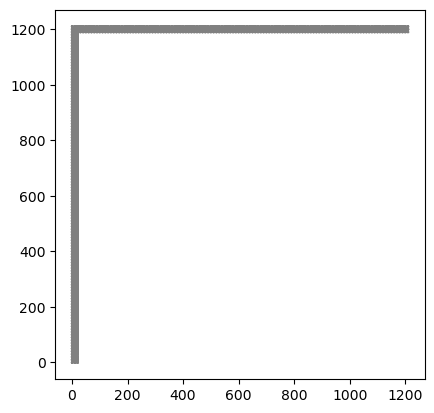

In [2]:
# Create mesh and define function space
h = 10
L = 1200
l1 = L / 5
E = 7200
nu = 0

mesh = Mesh('mesh/lees-frame-2d.xml')
V = VectorFunctionSpace(mesh, "Lagrange", 1)

# Define functions for the arc length method
du = TrialFunction(V)            # Incremental displacement
v  = TestFunction(V)             # Test function
u = Function(V)                 # Solution

plot(mesh)

## Define Dirichlet Boundary Conditions

In [3]:
def Hinge1(x, on_boundary):
    return near(x[0], 2*h, 1e-6) and near(x[1], 0.0, 1e-6)
    
def Hinge2(x, on_boundary):
    return near(x[0], L+h, 1e-6) and near(x[1], L-h, 1e-6)

def force(x,on_boundary):
    return between(x[0],[l1-l1/25,l1+l1/25]) #and near(x[1],L-h,1e-6)

facets = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
facets.set_all(0)
AutoSubDomain(force).mark(facets,1)

bc1 = DirichletBC(V, Constant((0.0, 0.0)), Hinge1, method='pointwise')
bc2 = DirichletBC(V, Constant((0.0, 0.0)), Hinge2, method='pointwise')
bcs = [bc1, bc2]

## Define Function for Point Load
Note that this is an approximation of a point load since the FEniCS UserExpression will be projected into a discontinuous space. To approach a point load the area near the point load will need to have fine mesh. In our case it is not neccessary since the point load is just a perturbation.

In [4]:
# Function for Point Load
class PointLoad(UserExpression):
    def __init__(self, x0, f, tol,**kwargs):
        super().__init__(**kwargs)
        self.x0 = x0
        self.f = f
        self.tol = tol
    def eval(self, values, x):
        if near (x[0], self.x0[0],self.tol) and near(x[1], self.x0[1],self.tol):
            values[0] = self.f[0]
            values[1] = self.f[1]
        else:
            values[0] = 0
            values[1] = 0
    def value_shape(self):
        return (2,)

## Kinematics and Weak Form

In [5]:
# Kinematics
I = Identity(mesh.topology().dim())    # Identity tensor
F = I + grad(u)                        # Deformation gradient
C = F.T*F                              # Right Cauchy-Green tensor

# Invariants of deformation tensors
Ic = tr(C)
J  = det(F)

# Elasticity parameters
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))

# Stored strain energy density (compressible neo-Hookean model)
psi = (mu/2)*(Ic - 3) - mu*ln(J) + (lmbda/2)*(ln(J))**2

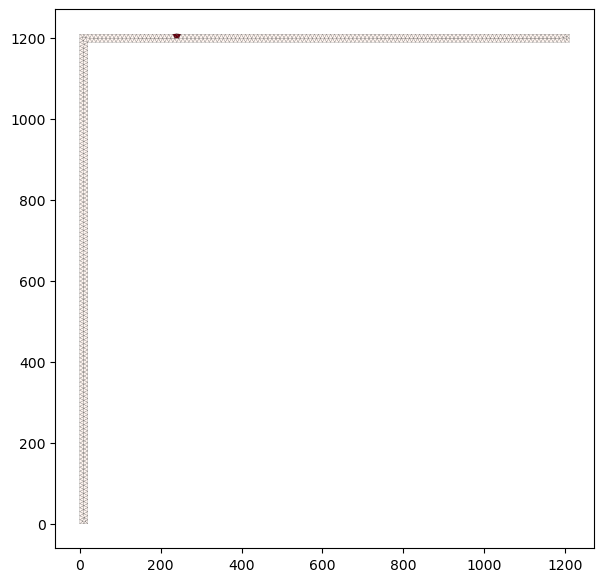

In [6]:
# Applied Traction and Body Force
load = Expression("-t", t=0, degree = 0)
T = Constant((0,1)) # Traction
B = Constant((0,0)) # Body Force
P = PointLoad(x0 = [l1,L+h], f = [0,1], tol = 1e-4, degree = 5, element=V.ufl_element()) # Point load

# define sub domains
ds = Measure('ds', domain=mesh, subdomain_data=facets)

# Solve Variational Problem - Arc Length Method
F_int = derivative(psi*dx, u, v)
F_ext = derivative(dot(B, u)*dx + load*dot(P,u)*ds , u, v)
residual = F_int-F_ext
J = derivative(residual, u, du)

# Plot the point load function
plt.figure(figsize = (7,7))
plot(project(P,V), mode = 'displacement', edgecolor = 'k', cmap = 'Reds', linewidth = 0.1)

## Solver
To use our solver we first have to define the type of solver (i.e. displacement control or force control) and solver parameters before using the solver. Note that the correct type of solver has to first be imported (see first cell).
### Solver parameters
Here the parameters for both types of solvers:

>* `psi` : the scalar arc-length parameter. When psi = 1, the method becomes the spherical arc-length method and when psi = 0 the method becomes the cylindrical arc-length method
>* `abs_tol` *(optional)* : absolute residual tolerance for the linear solver (default value: 1e-10)
>* `rel_tol` *(optional)* :  relative residual tolerance for solver; the relative residual is defined as the ration between the current residual and initial residual (default value: DOLFIN_EPS)
>* `lmbda0` : the initial load parameter
>* `max_iter` : maximum number of iterations for the linear solver
>* `solver` *(optional)*: type of linear solver for the FEniCS linear solve function -- default FEniCS linear solver is used if no argument is used.

Aside from these solver parameters, the arguments need to solve the FEA problem must also be passed into the solver:
>* `u` : the solution function
>* `F_int` : First variation of strain energy (internal nodal forces)
>* `F_ext` : Externally applied load (external applied force)
>* `J` : The Jacobian of the residual with respect to the deformation (tangential stiffness matrix)
>* `displacement_factor` : The incremental displacement factor 

The solver can be called by:

`solver = force_control(psi,abs_tol,rel_tol,lmbda0,max_iter,u,F_int,F_ext,bcs,J,displacement_factor,solver)`

### Using the solver
1. Initialize the solver by calling solver.initialize()
2. Iteratively call solver.solve() until desired stopping condition

In [7]:
# Solver Parameters
psi = 1.0
abs_tol = 1.0e-6
lmbda0 = 4.0
max_iter = 30

# Set up arc-length solver
solver = force_control(psi=psi, abs_tol=abs_tol, lmbda0=lmbda0, max_iter=max_iter, u=u,
                       F_int=F_int, F_ext=F_ext, bcs=bcs, J=J, load_factor=load)

In [8]:
disp = [u.vector()[:]]
lmbda = [0]

for ii in range(0,38):
    solver.solve()
    if solver.converged:       
        disp.append(u.vector()[:])
        lmbda.append(load.t)

Initializing solver parameters...
Starting initial Force Control with Newton Method:
Iteration 0: | 
Absolute Residual: 2.8284e+01| Relative Residual: 1.0000e+00
Iteration 1: | 
Absolute Residual: 1.2595e+04| Relative Residual: 4.4530e+02
Iteration 2: | 
Absolute Residual: 1.3625e+02| Relative Residual: 4.8172e+00
Iteration 3: | 
Absolute Residual: 4.5732e+03| Relative Residual: 1.6169e+02
Iteration 4: | 
Absolute Residual: 1.5026e+01| Relative Residual: 5.3124e-01
Iteration 5: | 
Absolute Residual: 3.6557e+02| Relative Residual: 1.2925e+01
Iteration 6: | 
Absolute Residual: 1.0960e-01| Relative Residual: 3.8749e-03
Iteration 7: | 
Absolute Residual: 1.1267e-01| Relative Residual: 3.9836e-03
Iteration 8: | 
Absolute Residual: 8.9173e-09| Relative Residual: 3.1528e-10

Arc-Length Step 1 :
Iteration: 0 
|Total Norm: 8.9295e-09 |Residual: 8.9173e-09 |A: 4.6566e-10| Relative Norm : 1.0000e+00

Arc-Length Step 2 :
Iteration: 0 
|Total Norm: 4.6279e+04 |Residual: 4.6279e+04 |A: 4.6566e-10| R

## Post Processing
Here we plot the final deformed shape and the equilibrium path.

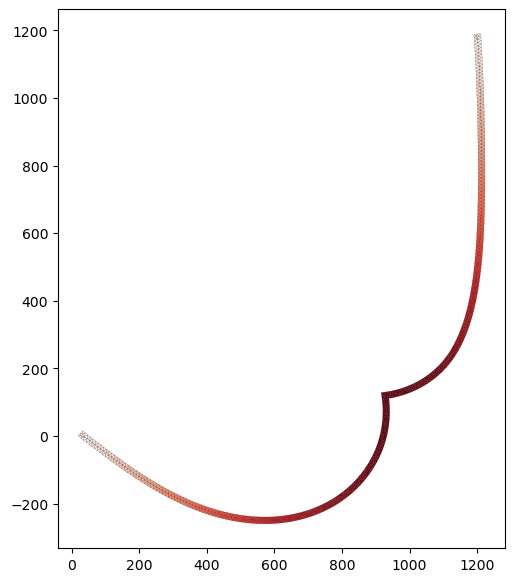

In [9]:
# Plot final deformation
plt.figure(figsize=(7,7))
plot(u, mode = 'displacement', cmap = 'Reds', edgecolor= 'k', linewidth = 0.1)

Text(0, 0.5, 'Load Factor')

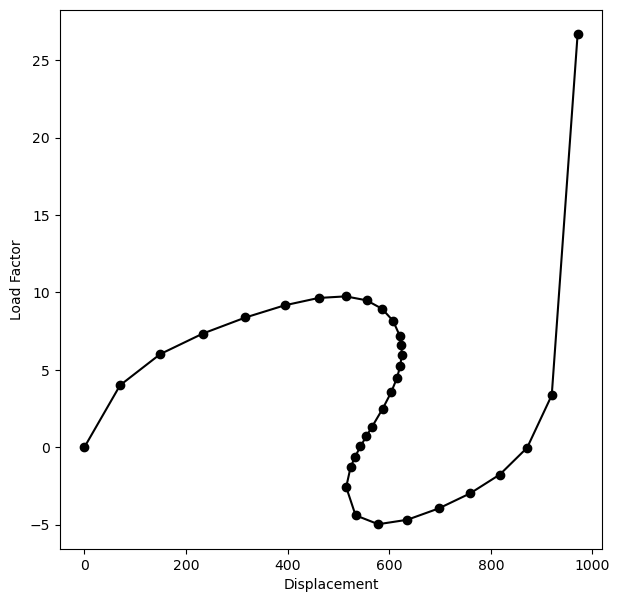

In [10]:
# get force dof
y_dofs = V.sub(1).dofmap().dofs()
dof_coords = V.tabulate_dof_coordinates().reshape((-1, 2))

eps = 1e-5
for kk in y_dofs:
    if dof_coords[kk,1] >= L+h:
        if l1-eps < dof_coords[kk,0] < l1+eps:
            force_node = kk

force_disp = []
for ii in range(0,len(disp)):
    force_disp.append(-disp[ii][force_node])

plt.figure(figsize=(7,7))

plt.plot(force_disp,lmbda, marker = 'o', color = 'k')
plt.xlabel('Displacement')
plt.ylabel('Load Factor')

## Optional: Creating an animation from solution snapshots

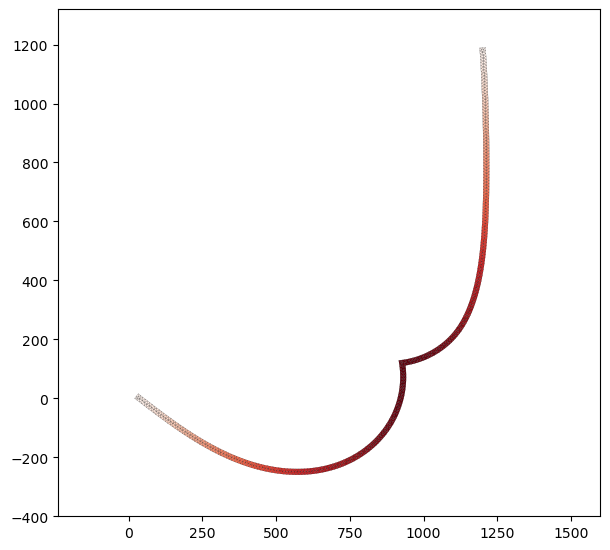

In [11]:
from matplotlib import animation, rc

plt.rcParams["animation.html"] = "jshtml"

u_plot = Function(V)

fig = plt.figure(figsize=(7,7))
ax = fig.gca()

ax.set_xlim([-L/5,L+L/5])
ax.set_ylim([-L/5,L+L/5])

def drawframe(n):
    fig.clf()
    ax = fig.gca()
    ax.set_xlim([0,L])
    ax.set_xlim([-L/5,L+L/3])
    ax.set_ylim([-L/3,L+L/10])
    u_plot = Function(V)
    u_plot.vector()[:] = disp[n][:]
    p = plot(u_plot, mode = 'displacement', cmap = 'Reds', edgecolor= 'k', linewidth = 0.1)
    return p,
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(lmbda), interval=40, blit=True)
anim